In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time

import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

from matplotlib.lines import Line2D
import multiprocessing as mp

import pandas as pd
import seaborn as sns

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

from matplotlib.lines import Line2D
me.mechanics_printing()

In [388]:
p = mf.ModelParameters.DynamicModel(3)

p.m_t = mf.ModelSymbol(value = 1,string = 'm_t')      # mass of tank
p.m_b = mf.ModelSymbol(value = 1,string = 'm_b')      # mass of ball
p.m_p = mf.ModelSymbol(value = 1,string = 'm_p')      # mass of pendulum
p.l_p = mf.ModelSymbol(value = 1,string = 'l_p')      # pivot
p.t_h = mf.ModelSymbol(value = 1,string = 't_h')      # tank height
p.k_t = mf.ModelSymbol(value = 0,string = 'k_t')      # tank spring
p.k_b = mf.ModelSymbol(value = 0,string = 'k_b')      # ball spring
p.k_p = mf.ModelSymbol(value = 0,string = 'k_p')      # ball spring
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')    # gravity
    

#define refernce frames
tank_frame = mf.HomogenousTransform().Translate(0,0,p.q[0])
ball_frame = mf.HomogenousTransform().Translate(0,0,p.q[1])
pendulum_frame = ball_frame.R_x(p.q[2]).Translate(0,0,p.l_p)

#Create Elemnts
ball_ele = ele.RigidElement.PointMass(ball_frame,p.m_b,gravityPotential = True)
pen_ele = ele.RigidElement.PointMass(pendulum_frame,p.m_p,gravityPotential = True)
tank_ele = ele.RigidElement.PointMass(tank_frame,p.m_t,gravityPotential = False)

# Setup External Force
tank_spring_ele = ele.Spring(p.q[0],p.k_t)
ball_spring_ele = ele.Spring(p.q[1],p.k_b)
pendulum_spring_ele = ele.Spring(p.q[2],p.k_p)

def q_func(constants,x,t):
    if abs(x[0]-x[2])+0.1>p.t_h.value/2:
        return (0,0,0)
    else:
        return (0,0,0)


custom_force = ef.CustomForce(q_func)


sm = mf.SymbolicModel.FromElementsAndForces(p,[tank_spring_ele,ball_spring_ele,pen_ele,tank_ele,ball_ele,pendulum_spring_ele],custom_force)

In [389]:
ball_ele.CalcKE(p)

In [390]:
sm.M

⎡mₜ        0               0       ⎤
⎢                                  ⎥
⎢0      m_b + mₚ     -lₚ⋅mₚ⋅sin(q₂)⎥
⎢                                  ⎥
⎢                          2       ⎥
⎣0   -lₚ⋅mₚ⋅sin(q₂)      lₚ ⋅mₚ    ⎦

In [391]:
sm.f

⎡                  kₜ⋅q₀                  ⎤
⎢                                         ⎥
⎢                                        2⎥
⎢g⋅m_b + g⋅mₚ + k_b⋅q₁ - lₚ⋅mₚ⋅cos(q₂)⋅q₂̇ ⎥
⎢                                         ⎥
⎣        -g⋅lₚ⋅mₚ⋅sin(q₂) + kₚ⋅q₂         ⎦

In [411]:
p.m_b.value = 0.036*0.4
p.m_t.value = .240

p.m_p.value = 0.036*0.6
p.l_p.value = 0.01
p.k_t.value = 1000
p.k_p.value = 0.0001
p.t_h.value = 0.01
p.g.value = 9.81
      


#Define the reaction force
def gust(t,x):
    if abs(x[0]-x[2])>p.t_h.value/2:
        return abs(x[0]-x[2])*2000000
    else:
        return 0
p.k_b.value = gust

def ext_force(constants,x,t):
    if abs(x[0]-x[2])>p.t_h.value/2:
        return np.array([[-x[1]*0.1],[-x[3]*0.1],[0]])
    else:
        return np.array([[-x[1]*0.1],[0],[0]])

sm.ExtForces = ef.CustomForce(ext_force)
nm = mf.NumericModel.from_SymbolicModel(p,sm)

# Define Objective Function for solver
def objectiveDeriv(t,y):
    tup = p.GetNumericTuple(y,t)
    return nm.deriv(t,y,tup)

# Generate I.C. and run the solver
x = [0]*p.qs*2
x[0] = -0.01
x[2] = -0.01
x[4] = -0.1
end_time = 1
yData = solve_ivp(objectiveDeriv,(0,end_time),x,max_step=0.01,method = "RK45")

In [412]:
y=[-0.01,0,-0.01,0,0.1,0]
tup = p.GetNumericTuple(y,0)
nm.deriv(0,y,p.GetNumericTuple(y,0))

In [413]:
#interpolate to reduce t and y points
int_func = interp1d(yData.t,yData.y)

t = np.linspace(0,end_time,(end_time*1000)+1)
yi = int_func(t)

a_i = []
e = []

for i in range(len(t)):
    y = yi[:,i]
    tup = p.GetNumericTuple(y,0)
    a_i.append(nm.deriv(0,y,tup))
    e.append(nm.Energy(0,y,tup))
a_i = np.array(a_i)  



#populate list of data
ls = []        
for i in range(len(t)):
    ls.append({'t':t[i],'e':e[i],**{f'x{j}':yi[j,i] for j in range(p.qs*2)},**{f'a{j}':a_i[i,j] for j in [1,3]}})#'q1':yi[1,i]})
df = pd.DataFrame(ls)

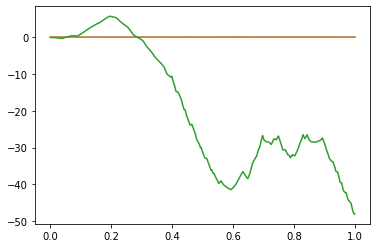

In [414]:
# plt.plot(df['t'],df['x0'])
plt.plot(df['t'],df['x0'])
plt.plot(df['t'],df['x2'])
plt.plot(df['t'],df['x4'])

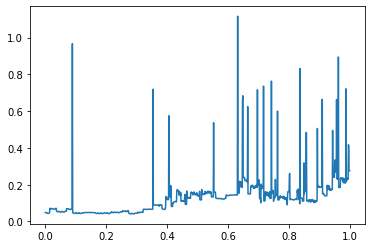

In [415]:
plt.plot(df['t'],df['e'])

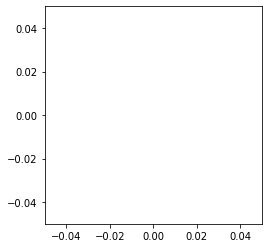

In [416]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.05, 0.05))
ax.set_ylim((-0.05, 0.05))
plt.gca().set_aspect('equal', adjustable='box')

line, = ax.plot([], [], lw=2)
box, = ax.plot([], [], lw=2)

In [417]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    box.set_data([], [])
    return (line,box)
# animation function. This is called sequentially
def animate(i):
    x_box = [-2,2,2,-2,-2]
    y_box = [yi[0,i]-p.t_h.value/2,yi[0,i]-p.t_h.value/2,yi[0,i]+p.t_h.value/2,yi[0,i]+p.t_h.value/2,yi[0,i]-p.t_h.value/2]    
    box.set_data(x_box, y_box)  
    x = np.array([0,0.02*np.sin(yi[4,i])])
    y = np.array([yi[2,i],yi[2,i]-np.cos(yi[4,i])*0.02])
    line.set_data(x, y)
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)
HTML(anim.to_html5_video())